![logo_ironhack_blue 7](https://user-images.githubusercontent.com/23629340/40541063-a07a0a8a-601a-11e8-91b5-2f13e4e6b441.png)

# Lab | Unsupervised learning intro

#### Instructions 


It's the moment to perform clustering on the songs you collected. Remember that the ultimate goal of this little project is to improve the recommendations of artists. Clustering the songs will allow the recommendation system to limit the scope of the recommendations to only songs that belong to the same cluster - songs with similar audio features.

The experiments you did with the `Spotify` API and the Billboard web scraping will allow you to create a pipeline such that when the user enters a song, you:

1. Check whether or not the song is in the Billboard Hot 200.
2. Collect the audio features from the `Spotify` API.

After that, you want to send the `Spotify` audio features of the submitted song to the clustering model, which should return a cluster number.

We want to have as many songs as possible to create the clustering model, so we will add the songs you collected to a bigger dataset available on Kaggle containing 160 thousand songs.

In [1]:
from bs4 import BeautifulSoup
import requests
import math
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
from tqdm.notebook import tqdm
from collections import defaultdict
import getpass

Spotify credentials

In [2]:
client_id = getpass.getpass(prompt='input client_id') 
client_secret = getpass.getpass(prompt='input client_secret')

input client_id········
input client_secret········


In [3]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id,
                                                           client_secret=client_secret))

Get "The Hot 100" Billboard Songs

In [61]:
url = "https://www.billboard.com/charts/hot-100"

In [62]:
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

In [63]:
titles = []
artists = []
for tag in soup.find_all('span', 'chart-element__information__song text--truncate color--primary'):
    titles.append(tag.get_text())
for tag in soup.find_all('span', 'chart-element__information__artist text--truncate color--secondary'):
    artists.append(tag.get_text())

top100 = pd.DataFrame({'title':titles, 'artist':artists})
top100.head()

,title,artist
0,Drivers License,Olivia Rodrigo
1,34+35,Ariana Grande
2,Calling My Phone,Lil Tjay Featuring 6LACK
3,Blinding Lights,The Weeknd
4,Up,Cardi B


In [64]:
top100.shape

(100, 2)

Get many songs from Spotify

In [65]:
user = 'spotify'

playlists = sp.user_playlists(user)
playlist_uri = []
playlist_names = []

while playlists:
    for playlist in playlists['items']:
        playlist_uri.append(playlist['uri'])
        playlist_names.append(playlist['name'])
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None

In [66]:
# playlist_names

In [67]:
def get_tracks_from_playlist(username, playlist_id):
    results = sp.user_playlist_tracks(username, playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    return tracks

In [68]:
def get_all_tracks(uri):

    s_id = []
    s_name = []
    s_artists = []
    
    results = get_tracks_from_playlist("",uri)
    c = 0
    for i in results:
        if i['track'] != None:
            s_id.append("missing value" if i['track']['id'] == None else i['track']['id'])
            s_name.append(i['track']['name'])
            s_artists.append([j['name'] for j in i['track']['artists']])

    return {'song_id':s_id, 'song_name':s_name, 'artists':s_artists}

In [69]:
songs = {'song_id':[], 'song_name':[], 'artists':[]}

for i in tqdm(playlist_uri):
    d = get_all_tracks(i)
    [songs['song_id'].append(i) for i in d['song_id']]
    [songs['song_name'].append(i) for i in d['song_name']]
    [songs['artists'].append(i) for i in d['artists']]

  0%|          | 0/1396 [00:00<?, ?it/s]

In [70]:
df_songs = pd.DataFrame(songs)
df_songs

,song_id,song_name,artists
0,5Kskr9LcNYa0tpt5f0ZEJx,Calling My Phone,"[Lil Tjay, 6LACK]"
1,5uEYRdEIh9Bo4fpjDd4Na9,Goosebumps - Remix,"[Travis Scott, HVME]"
2,1diS6nkxMQc3wwC4G1j0bh,We're Good,[Dua Lipa]
3,5QO79kh1waicV47BqGRL3g,Save Your Tears,[The Weeknd]
4,7lPN2DXiMsVn7XUKtOW1CS,drivers license,[Olivia Rodrigo]
...,...,...,...
102940,5kqIPrATaCc2LqxVWzQGbk,7 Years,[Lukas Graham]
102941,3FCto7hnn1shUyZL42YgfO,Piano Man,[Billy Joel]
102942,3XVBdLihbNbxUwZosxcGuJ,If I Ain't Got You,[Alicia Keys]
102943,6QPKYGnAW9QozVz2dSWqRg,Someone Like You,[Adele]


Remove the duplicates

In [71]:
df_songs = df_songs.drop_duplicates(subset='song_id').reset_index(drop=True)
df_songs

,song_id,song_name,artists
0,5Kskr9LcNYa0tpt5f0ZEJx,Calling My Phone,"[Lil Tjay, 6LACK]"
1,5uEYRdEIh9Bo4fpjDd4Na9,Goosebumps - Remix,"[Travis Scott, HVME]"
2,1diS6nkxMQc3wwC4G1j0bh,We're Good,[Dua Lipa]
3,5QO79kh1waicV47BqGRL3g,Save Your Tears,[The Weeknd]
4,7lPN2DXiMsVn7XUKtOW1CS,drivers license,[Olivia Rodrigo]
...,...,...,...
81657,3Zuf70897YkrVRAsrBMMSF,"You're The One That I Want - From ""Grease"" Ori...","[John Travolta, Olivia Newton-John]"
81658,1MDoll6jK4rrk2BcFRP5i7,Hello,[Adele]
81659,0ygTmpa6uSotkBkTiwcMZ4,Warwick Avenue,[Duffy]
81660,7GJClzimvMSghjcrKxuf1M,Budapest,[George Ezra]


Let's get the features, 100 ids at a time

In [72]:
features_list = []
for i in tqdm(range(math.ceil(df_songs.shape[0]/100))):
    features_list.append(sp.audio_features(df_songs['song_id'].to_list()[i*100:(i+1)*100]))

  0%|          | 0/817 [00:00<?, ?it/s]

In [73]:
features = []
[[(features.append(j) if j != None else None) for j in i] for i in features_list]
pass

In [74]:
dic = defaultdict(list)
{dic[key].append(f[key]) for f in features for key in f}  
df_features = pd.DataFrame(dict(dic))

In [75]:
df_songs.shape

(81662, 3)

In [76]:
df_features.shape

(81576, 18)

In [77]:
df_features = df_features[df_features['speechiness']<0.8]

In [78]:
df_all = df_songs.merge(df_features.rename({'id':'song_id'}, axis=1), on='song_id', how='right')
df_all.columns

Index(['song_id', 'song_name', 'artists', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [79]:
df_all = df_all.drop(['type', 'uri', 'track_href', 'analysis_url'], axis=1)

In [80]:
df_all.head()

,song_id,song_name,artists,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,5Kskr9LcNYa0tpt5f0ZEJx,Calling My Phone,"[Lil Tjay, 6LACK]",0.907,0.393,4,-7.636,0,0.0539,0.4510,0.000001,0.135,0.202,104.949,205458,4
1,5uEYRdEIh9Bo4fpjDd4Na9,Goosebumps - Remix,"[Travis Scott, HVME]",0.841,0.593,1,-7.846,1,0.0379,0.4180,0.000000,0.124,0.808,124.917,162803,4
2,1diS6nkxMQc3wwC4G1j0bh,We're Good,[Dua Lipa],0.722,0.588,6,-5.932,1,0.0544,0.0319,0.000000,0.183,0.590,134.010,165507,4
3,5QO79kh1waicV47BqGRL3g,Save Your Tears,[The Weeknd],0.680,0.826,0,-5.487,1,0.0309,0.0212,0.000012,0.543,0.644,118.051,215627,4
4,7lPN2DXiMsVn7XUKtOW1CS,drivers license,[Olivia Rodrigo],0.585,0.436,10,-8.761,1,0.0601,0.7210,0.000013,0.105,0.132,143.874,242014,4


Feature selection

In [81]:
X_cont = df_all[['danceability','energy','loudness','speechiness',
                       'acousticness','instrumentalness','liveness','valence',
                       'tempo','duration_ms']]

In [82]:
X_disc = df_all[['key','mode','time_signature']]

Standardize

In [83]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_cont_st = scaler.fit_transform(X_cont)
X_cont_st = pd.DataFrame(X_cont_st, columns=X_cont.columns)

No need to encode the discrete variables

In [84]:
X_disc = X_disc.astype('object')
X_disc

,key,mode,time_signature
0,4,0,4
1,1,1,4
2,6,1,4
3,0,1,4
4,10,1,4
...,...,...,...
76291,0,1,4
76292,5,0,4
76293,0,0,4
76294,5,1,4


Join all features

In [85]:
X_prep = pd.concat([X_cont_st, X_disc], axis=1)
X_prep

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key,mode,time_signature
0,1.951242,-0.498901,0.432216,-0.297020,0.167328,-0.597743,-0.311410,-0.867494,-0.390703,-0.219755,4,0,4
1,1.604944,0.188210,0.402628,-0.434974,0.077949,-0.597746,-0.381398,1.454091,0.234270,-0.490548,1,1,4
2,0.980559,0.171032,0.672303,-0.292709,-0.967785,-0.597746,-0.006007,0.618934,0.518870,-0.473382,6,1,4
3,0.760188,0.988694,0.735002,-0.495328,-0.996766,-0.597711,2.284515,0.825807,0.019373,-0.155197,0,1,4
4,0.261729,-0.351172,0.273708,-0.243563,0.898610,-0.597709,-0.502286,-1.135663,0.827600,0.012319,10,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
76291,1.132720,0.737899,0.353032,0.044414,-0.439366,-0.595498,0.159420,1.323837,-0.327260,-0.454591,0,1,4
76292,-0.336421,-0.368350,0.644547,-0.466875,-0.163104,-0.597746,-0.626993,-0.534197,1.269100,0.351886,5,0,4
76293,-0.220989,0.177903,0.688929,-0.423765,-0.136019,-0.597746,-0.400486,0.281806,1.642432,-0.086888,0,0,4
76294,0.938584,-0.299639,0.343170,-0.523781,-0.815029,-0.597746,-0.483199,-0.085970,0.324098,-0.249834,5,1,4


Subset of X just for practical purposes (faster processing)

In [86]:
# With 1000 samples we get 7 clusters
X_prep = X_prep.sample(50000)

Cluster

In [87]:
from sklearn.cluster import KMeans

Text(0.5, 1.0, 'Elbow Method showing the optimal k within [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]')

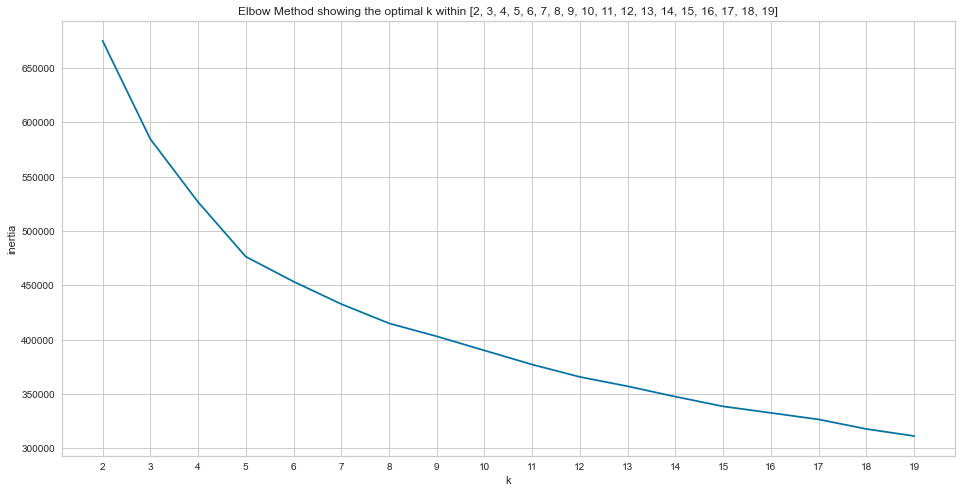

In [88]:
K = range(2,20)
inertias = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234,
                   )
    kmeans.fit(X_prep)
    inertias.append(kmeans.inertia_)
    
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Elbow Method showing the optimal k within {list(K)}')

In [89]:
from sklearn.metrics import silhouette_score

import numpy as np
K = range(2,20)
silhouettes = []

for k in tqdm(K):
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(X_prep)
    silhouettes.append(silhouette_score(X_prep, kmeans.predict(X_prep) )
                   )
    
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title(f'Silhouette Method showing the optimal k within {list(K)}')

  0%|          | 0/18 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,12))
for k in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=k,
                random_state=1234)
    q, mod = divmod(k, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X_prep)

We decide for 7 clusters

In [90]:
cols = X_prep.columns

In [91]:
kmeans = KMeans(n_clusters=7,
               random_state=1234)
kmeans.fit(X_prep)

clusters = kmeans.predict(X_prep)

In [92]:
clusters.shape

(50000,)

In [93]:
songs_clustered = X_prep.copy()
songs_clustered['cluster_id'] = clusters

In [94]:
songs_clustered

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,key,mode,time_signature,cluster_id
22579,0.487347,-0.485159,0.059827,-0.497915,1.036741,-0.597311,-0.483199,0.396736,-0.612673,-0.293429,0,1,4,1
70702,0.991053,0.188210,0.417422,-0.278052,0.018363,-0.597743,-0.580546,0.101749,0.703094,-0.558223,9,1,4,0
50439,0.775929,-1.658057,-2.174082,5.247842,0.121284,-0.597746,-0.606632,-0.875156,0.571984,1.825350,5,0,3,4
47596,0.062346,-0.753132,-0.262684,-0.515159,1.258834,-0.597391,-0.260509,-0.177914,-0.929009,-0.235359,5,1,3,3
319,-0.703707,-1.823548,-3.047920,-0.311678,1.640726,2.095304,-0.451386,-1.170142,0.024412,-0.501531,8,1,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7025,1.132720,-0.533256,-0.042181,0.436719,-0.922554,-0.597739,1.756423,-0.599324,0.082065,-0.144894,0,1,4,1
51890,-1.611426,-1.692412,-1.929486,-0.436698,1.613642,1.754012,-0.419573,-0.384788,-0.777555,-0.692194,4,0,3,5
57059,-2.235811,-1.705468,-1.914973,-0.386690,1.093619,1.992056,-0.438661,-1.324148,-1.478146,0.159039,9,1,3,6
36698,0.760188,0.329068,0.379803,-0.275465,-0.837238,-0.589860,0.897477,2.013417,0.981121,-0.293848,5,1,4,3


In [95]:
cluster_centers_df = pd.DataFrame(kmeans.cluster_centers_, columns=cols)
cluster_centers_df['cluster_id'] = range(0,7)

In [96]:
# we can only plot 2 dimensions,
# so we take 'danceability', 'loudness'
# we also need the 'cluster_id' to color the dots with
clusters_sub_df = cluster_centers_df[['danceability', 'loudness', 'cluster_id']]
songs_sub_df = songs_clustered[['danceability', 'loudness', 'cluster_id']]

<AxesSubplot:xlabel='danceability', ylabel='loudness'>

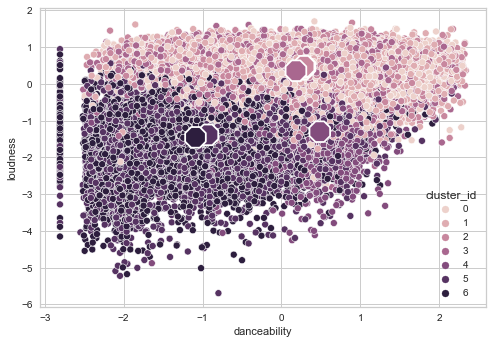

In [97]:
import seaborn as sns

# plot datapoints
sns.scatterplot(data=songs_sub_df,
               x="danceability",
               y="loudness",
               hue='cluster_id')

# plot centroids
sns.scatterplot(data=clusters_sub_df,
               x="danceability",
               y="loudness",
               hue='cluster_id',
                legend=False,
                marker=u'8',
                s=500,
               )


Is a song in the Top 100 list?

In [98]:
def is_hot(song):
    s = top100['title'].str.contains(song, na=False, case=False)
    if s.sum() > 0:
        return True
    else:
        return False

In [99]:
is_hot('Drivers')

True

Ask for user input and recommend song

In [100]:
def recommend():
    print("""
    Enter your song's name. Example:
    >>> where is love?
    """)
    user_input = input()
    
    if is_hot(user_input):
        
        s = top100[top100['title'].str.contains('love', na=False, case=False)].sample()
        
        print('Match found!')
        print('* ' + '"' + s.iloc[0]['title'] + '"' + ' by ' + s.iloc[0]['artist'])
        s = top100.sample()
        print("""Your song is hot!\nHere's another one for you to check out:""")
        print('* ' + '"'+s.iloc[0]['title']+'"' + ' by ' + s.iloc[0]['artist'])
    else:
        
        result = sp.search(q=user_input, type='track', limit=1)
        song_audio_features = sp.audio_features(result['tracks']['items'][0]['id'])
        song_audio_features_df = pd.DataFrame(song_audio_features, columns=X_cont.columns)
        song_scaled = pd.DataFrame(scaler.transform(song_audio_features_df))
        song_disc = pd.DataFrame(song_audio_features, columns=['key','mode','time_signature'])
        song_audio_features = pd.concat([song_scaled,song_disc], axis=1)
        cl = kmeans.predict(song_audio_features)[0]
        recommendation = df_all.iloc[songs_clustered[songs_clustered.cluster_id==cl].sample().index]

        print("""Your song is not in the Top 100.\nThis match was found:""")
        print("* " + str(result['tracks']['items'][0]['name']) +
              " by " +
              str(result['tracks']['items'][0]['artists'][0]['name']))
        print("Here's another one for you to check out:")
        print('* ' + str(recommendation.song_name.iloc[0]) +
              " by "
              + str([i for i in recommendation.artists.iloc[0]][0]))
    pass

Execute

In [102]:
recommend()


    Enter your song's name. Example:
    >>> where is love?
    
bohemian rhapsody
Your song is not in the Top 100.
This match was found:
* Bohemian Rhapsody - Remastered 2011 by Queen
Here's another one for you to check out:
* Make Me (Cry) - Acoustic by Boreal
